# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
from sklearn.externals import joblib
%matplotlib inline
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stephengriggs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

In [2]:
df = pd.read_csv("data/labeled_data.csv")

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


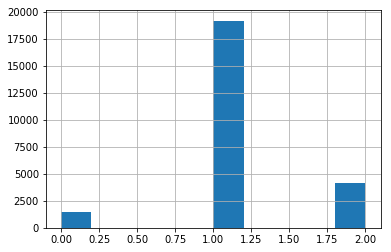

In [6]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [7]:
tweets=df.tweet
tweets = [x for x in tweets if type(x)==str]

## Feature generation

In [8]:
import string
stopwords = stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-\:]+'
    emoji_regex = '&#[0-9\;\:]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text = re.sub(emoji_regex,'',parsed_text)
    parsed_text = parsed_text.strip(string.punctuation)
    return parsed_text

def tokenize(tweet):

    tokens = []
    # remove non-alphabetic characters
    tweet_text = tweet_text = re.sub("[^a-zA-Z]"," ", str(tweet))

    #remove html content
    tweet_text = BeautifulSoup(tweet_text).get_text()

    # tokenize
    words = word_tokenize(tweet_text.lower())

    # lemmatize each word to its lemma
    lemma_words = [lemmatizer.lemmatize(i) for i in words]

    tokens.append(lemma_words)
        
    return(tokens[0])
#     """Removes punctuation & excess whitespace, sets to lowercase,
#     and stems tweets. Returns a list of stemmed tokens."""
#     tweet = " ".join(re.split('\s|(?<!\d)[,.]|[,.](?!\d)', tweet.lower())).strip(string.punctuation).strip()
#     tokens = [stemmer.stem(t) for t in tweet.split()]
#     return tokens
     

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<< This is different 
    )

In [9]:

print(tweets[1526])
tokenize(preprocess(tweets[1526]))



&#8220;@SoTribe_Kasey: I surrounded my bad bitches I can't keep them out my face&#8221;&#128064;&#128064; #WhereTheyAtDoe &#128514;


['i',
 'surrounded',
 'my',
 'bad',
 'bitch',
 'i',
 'can',
 't',
 'keep',
 'them',
 'out',
 'my',
 'face',
 'wheretheyatdoe']

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
thing = (vectorizer.get_feature_names())
print(thing)

['ab', 'ability', 'able', 'abo', 'abortion', 'absolute', 'absolutely', 'abt', 'accent', 'accept', 'accident', 'accidentally', 'according', 'account', 'accurate', 'across', 'act', 'act like', 'act like bitch', 'actin', 'actin like', 'acting', 'acting like', 'acting like bitch', 'action', 'active', 'activity', 'actor', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'addicted', 'address', 'admit', 'adorable', 'adult', 'advice', 'ae', 'af', 'afford', 'afraid', 'african', 'afterwards', 'ag', 'age', 'ago', 'agree', 'agreed', 'ah', 'ah bitch', 'aha', 'ahaha', 'ahead', 'ahh', 'ahhh', 'aid', 'aim', 'ainn', 'aint', 'aint bitch', 'aint even', 'aint fuckin', 'aint fucking', 'aint got', 'aint hoe', 'aint hoe get', 'aint loyal', 'aint never', 'aint nobody', 'aint nothing', 'aint shit', 'aint shit bitch', 'air', 'aka', 'al', 'al qaeda', 'alabama', 'alarm', 'albino', 'album', 'alcohol', 'alert', 'alex', 'alex smith', 'alien', 'alike', 'alive', 'allah', 'allen', 'allowed', 'almost', 'almost got', 

In [13]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [14]:
tweet_tags

['NN VBZ DT NN DT NN NN VBD DT JJ NN NN JJ NN NN JJ JJ NN NN JJ NN NN IN JJ NN VBD DT NN VBP DT NN NN JJ NN NN NN VBZ DT NN NN VBP NN JJ NN NN NN JJ NN NN JJ JJ NN NN . DT NN NN DT NN DT NN DT JJ NN NN JJ NN NN JJ JJ NN VBZ DT NN WRB DT NN NN VBZ DT NN NN NN NN NN NN VBZ DT JJ NN NN JJ NN',
 'NN NN NN NN NN VBZ DT JJ NN NN NN NN NN . . . JJ NN VBD DT NN NN NN VBD DT NN NN NN NN NN JJ JJ NN NN VBP VBZ DT NN NN IN NN NN VBP NN NN NN NN NN NN VBZ DT NN NN',
 'NN NN VBZ DT JJ NN . . . . NN NN NN NN JJ NN NN NN NN NN JJ NN VBD DT NN NN VBP NN NN DT JJ NN NN NN NN NN VBD DT NN NN NN NN NN NN NN . UH NN JJ NN NN NN NN JJ NN JJ NN NN VBZ DT JJ NN NN NN VBP',
 'NN NN NN NN NN NN NN NN NN NN NN VBP VBZ DT NN NN DT JJ NN NN',
 'NN NN NN NN NN NN NN JJ VBP JJ NN JJ NN VBZ DT NN DT NN NN JJ NN NN IN NN NN VBP NN NN NN NN NN NN JJ NN IN NN NN VBP NN NN VBP NN NN NN NN VBZ DT NN NN NN NN VBD DT JJ NN NN NN NN NN VBP NN NN NN NN JJ NN NN NN NN NN VBP NN NN VBZ DT',
 'NN NN NN NN NN JJ VBP NN JJ NN NN 

In [15]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [16]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [17]:
pos_stuff = pos_vectorizer.get_feature_names()
pos_stuff

['CC',
 'CC DT',
 'CC DT JJ',
 'CC DT NN',
 'CC FW',
 'CC IN',
 'CC JJ',
 'CC JJ IN',
 'CC JJ JJ',
 'CC JJ NN',
 'CC NN',
 'CC NN IN',
 'CC NN NN',
 'CC NN VBP',
 'CC VBP',
 'CC VBZ',
 'CC VBZ DT',
 'CD',
 'CD NN',
 'DT CC',
 'DT CC JJ',
 'DT DT',
 'DT DT DT',
 'DT DT JJ',
 'DT DT NN',
 'DT FW',
 'DT FW DT',
 'DT JJ',
 'DT JJ IN',
 'DT JJ JJ',
 'DT JJ NN',
 'DT JJ NNP',
 'DT JJ VBP',
 'DT NN CC',
 'DT NN DT',
 'DT NN FW',
 'DT NN IN',
 'DT NN JJ',
 'DT NN MD',
 'DT NN NNP',
 'DT NN UH',
 'DT NN VB',
 'DT NN VBD',
 'DT NN VBP',
 'DT NN VBZ',
 'DT NN WP',
 'DT NN WRB',
 'DT VB',
 'DT VB DT',
 'DT VBZ',
 'DT VBZ DT',
 'EX',
 'EX VB',
 'EX VB DT',
 'FW',
 'FW CC',
 'FW CC FW',
 'FW CC JJ',
 'FW DT',
 'FW DT DT',
 'FW DT JJ',
 'FW DT NN',
 'FW FW',
 'FW FW DT',
 'FW FW FW',
 'FW FW IN',
 'FW FW JJ',
 'FW FW NN',
 'FW FW VB',
 'FW FW VBP',
 'FW IN',
 'FW IN NN',
 'FW JJ',
 'FW JJ FW',
 'FW JJ JJ',
 'FW JJ NN',
 'FW NN',
 'FW NN DT',
 'FW NN FW',
 'FW NN IN',
 'FW NN JJ',
 'FW NN NN',
 'FW NN

In [18]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [19]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [20]:
feats = get_feature_array(tweets)
feats[0]

array([8.8000e+00, 7.3150e+01, 3.0000e+01, 1.3043e+00, 1.2000e+02,
       1.4000e+02, 2.5000e+01, 2.3000e+01, 2.1000e+01, 0.0000e+00,
       1.2000e-01, 8.8000e-01, 4.5630e-01, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00])

In [21]:
feats[0]

array([8.8000e+00, 7.3150e+01, 3.0000e+01, 1.3043e+00, 1.2000e+02,
       1.4000e+02, 2.5000e+01, 2.3000e+01, 2.1000e+01, 0.0000e+00,
       1.2000e-01, 8.8000e-01, 4.5630e-01, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00])

In [22]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [23]:
M.shape

(24783, 7516)

In [24]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [25]:
print(feature_names)

['ab', 'ability', 'able', 'abo', 'abortion', 'absolute', 'absolutely', 'abt', 'accent', 'accept', 'accident', 'accidentally', 'according', 'account', 'accurate', 'across', 'act', 'act like', 'act like bitch', 'actin', 'actin like', 'acting', 'acting like', 'acting like bitch', 'action', 'active', 'activity', 'actor', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'addicted', 'address', 'admit', 'adorable', 'adult', 'advice', 'ae', 'af', 'afford', 'afraid', 'african', 'afterwards', 'ag', 'age', 'ago', 'agree', 'agreed', 'ah', 'ah bitch', 'aha', 'ahaha', 'ahead', 'ahh', 'ahhh', 'aid', 'aim', 'ainn', 'aint', 'aint bitch', 'aint even', 'aint fuckin', 'aint fucking', 'aint got', 'aint hoe', 'aint hoe get', 'aint loyal', 'aint never', 'aint nobody', 'aint nothing', 'aint shit', 'aint shit bitch', 'air', 'aka', 'al', 'al qaeda', 'alabama', 'alarm', 'albino', 'album', 'alcohol', 'alert', 'alex', 'alex smith', 'alien', 'alike', 'alive', 'allah', 'allen', 'allowed', 'almost', 'almost got', 

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [26]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [29]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [30]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_,y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
y_preds = model.predict(X_)

In [32]:
report = classification_report( y, y_preds )

In [33]:
print(report)

              precision    recall  f1-score   support

           0       0.45      0.58      0.51      1430
           1       0.97      0.91      0.94     19190
           2       0.81      0.95      0.87      4163

   micro avg       0.90      0.90      0.90     24783
   macro avg       0.74      0.81      0.77     24783
weighted avg       0.91      0.90      0.90     24783



In [34]:
print(report) ### old report using x_train y_train when fitting model

              precision    recall  f1-score   support

           0       0.45      0.58      0.51      1430
           1       0.97      0.91      0.94     19190
           2       0.81      0.95      0.87      4163

   micro avg       0.90      0.90      0.90     24783
   macro avg       0.74      0.81      0.77     24783
weighted avg       0.91      0.90      0.90     24783



In [35]:
# joblib.dump(model, "model_py3.pkl")

['model_py3.pkl']

# Getting tfidf value & features for pickling vectorizer

In [36]:
final_features = select.get_support(indices=True) #get indices of features
final_feature_list = [(feature_names[i]) for i in final_features] #Get list of names corresponding to indices

In [37]:
print (final_feature_list)

['al', 'america', 'american', 'another', 'ape', 'bad', 'bad bitch', 'beaner', 'big', 'bird', 'bitch', 'bitch nigga', 'black', 'border', 'born', 'bout', 'breed', 'brownie', 'business', 'campus', 'charlie', 'chink', 'colored', 'colored folk', 'coming', 'coon', 'country', 'cracker', 'crazy', 'crow', 'cunt', 'da', 'damn', 'die', 'doe', 'dyke', 'face', 'fag', 'faggot', 'fat', 'female', 'feminist', 'filth', 'first', 'folk', 'fuck', 'fuckin', 'fucking', 'fuzzy', 'gay', 'get u', 'girl', 'go', 'gon', 'good', 'gook', 'got', 'got nigga', 'hate', 'hate hoe', 'hating', 'ho', 'hoe', 'hood', 'hope', 'human', 'ignorant', 'israel', 'jew', 'jihadi', 'kill', 'lame', 'let', 'like', 'like need', 'lol', 'look', 'look like', 'mexican', 'mock', 'money', 'monkey', 'muslim', 'muzzie', 'negro', 'never', 'nicca', 'niccas', 'nig', 'nigga', 'nigga amp', 'nigga bitch', 'niggah', 'niggaz', 'nigger', 'nigguh', 'niglet', 'nigs', 'oreo', 'people', 'pick', 'pussy', 'pussy boy', 'pussy nigga', 'queer', 'race', 'racist', '

In [38]:
#Getting names for each class of features
ngram_features = final_feature_list[:final_feature_list.index('zimmerman')+1]
pos_features = final_feature_list[final_feature_list.index('zimmerman')+1:final_feature_list.index('VBZ')+1]
oth_features = final_feature_list[final_feature_list.index('VBZ')+1:]

In [39]:
new_vocab = {v:i for i, v in enumerate(ngram_features)}
new_vocab_to_index = {}
for k in ngram_features:
    new_vocab_to_index[k] = vocab[k]

In [40]:
#Get indices of text features
ngram_indices = final_features[:len(ngram_features)]

In [41]:
### Pickle new dillerizer
new_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    min_df=1,
    max_df=1.0,
    vocabulary=new_vocab
    )

In [42]:

joblib.dump(new_vectorizer, 'omari_models/true_tfidf_py3.pkl') 

['omari_models/true_tfidf_py3.pkl']

In [43]:
#Verifying that tfidf of features is the same 
tfidf_ = new_vectorizer.fit_transform(tweets).toarray()

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [44]:
tfidf_[1,:]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [45]:
tfidf_[1,:].sum()

2.0

In [46]:
X_[1,:tfidf_.shape[1]]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       4.81346441, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.81887603, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [47]:
X_[1,:tfidf_.shape[1]].sum()

7.632340442426181

In [48]:
idf_vals_ = idf_vals[ngram_indices]

In [49]:
idf_vals_.shape

(161,)

In [50]:
#TODO: Pickle idf_vals

joblib.dump(idf_vals_, 'omari_models/idf_py3.pkl') 

['omari_models/idf_py3.pkl']

In [51]:
(tfidf_[1,:]*idf_vals_) == X_[1,:161] #Got same value as final process array!

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [52]:
tfidf_*idf_vals_ == X_[:,:161]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [53]:
tfidffinal = tfidf_*idf_vals_  ## in python model.py file this would be the tfidf_array * idk.pkl...
# #tfidf array is the result of tf_array = tf_vectorizer.fit_transform(tweets).toarray() where vectorizer is the tfidf_py3.pkl 


# Generating POS features

In [54]:
new_pos = {v:i for i, v in enumerate(pos_features)}

In [55]:
#TODO: Pickle pos vectorizer
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
new_pos_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    min_df=1,
    max_df=1.0,
    vocabulary=new_pos
    )

In [56]:
joblib.dump(new_pos_vectorizer, 'omari_models/pos_vect_py3.pkl') 

['omari_models/pos_vect_py3.pkl']

In [57]:
pos_ = new_pos_vectorizer.fit_transform(tweet_tags).toarray()

In [58]:
pos_new_items = new_pos_vectorizer.get_feature_names()
pos_new_items

['IN',
 'JJ JJ',
 'JJ NN JJ',
 'JJ VBP',
 'NN DT',
 'NN DT JJ',
 'NN JJ VBP',
 'NN NN VBZ',
 'NN VBZ',
 'NN VBZ DT',
 'VBD DT NN',
 'VBP JJ NN',
 'VBZ']

In [59]:
pos_[1,:]

array([1., 1., 0., 0., 0., 0., 0., 2., 2., 2., 2., 0., 3.])

In [60]:
X_[1,161:174]

array([1., 1., 0., 0., 0., 0., 0., 2., 2., 2., 2., 0., 3.])

In [61]:
pos_[:,:] == X_[:,161:174]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [62]:
pos_[:,:].sum()

223440.0

In [63]:
X_[:,161:174].sum()

223440.0

# Exploring other features

In [64]:
print (other_features_names) #original features input

['FKRA', 'FRE', 'num_syllables', 'avg_syl_per_word', 'num_chars', 'num_chars_total', 'num_terms', 'num_words', 'num_unique_words', 'vader neg', 'vader pos', 'vader neu', 'vader compound', 'num_hashtags', 'num_mentions', 'num_urls', 'is_retweet']


In [65]:
print (oth_features) ### comes from the output of select variable length is 14

['FKRA', 'FRE', 'num_syllables', 'avg_syl_per_word', 'num_chars', 'num_chars_total', 'num_terms', 'num_words', 'num_unique_words', 'vader neu', 'vader compound', 'num_hashtags', 'num_mentions', 'num_urls']


In [66]:
def other_features_(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    features = [FKRA, FRE, syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms,sentiment['neu'], sentiment['compound'],
                twitter_objs[2],twitter_objs[1],twitter_objs[0]]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array_(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features_(t))
    return np.array(feats)

In [67]:
feats_ = get_feature_array_(tweets)

In [68]:
len(feats_[0,:])

14

In [69]:
len(X_[0,174:])

14

In [70]:
feats_[:,:] == X_[:,174:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

 # Now that we have put it all together using a simplified process we can assess if these new data return the same answers.

In [71]:
M_ = np.concatenate([tfidffinal, pos_, feats_],axis=1)

In [72]:
M_.shape

(24783, 188)

In [73]:
X__ = pd.DataFrame(M_)

In [74]:
y_preds_ = model.predict(X__)

In [75]:
report = classification_report( y, y_preds_ )

In [76]:
print(report)

              precision    recall  f1-score   support

           0       0.45      0.58      0.51      1430
           1       0.97      0.91      0.94     19190
           2       0.81      0.95      0.87      4163

   micro avg       0.90      0.90      0.90     24783
   macro avg       0.74      0.81      0.77     24783
weighted avg       0.91      0.90      0.90     24783



# Using grid search

In [77]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [78]:
# pipe = Pipeline(
#         [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
#                                                   penalty="l1", C=0.01))),
#         ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [79]:
# param_grid = [{}] # Optionally add parameters here

In [80]:
# grid_search = GridSearchCV(pipe, 
#                            param_grid,
#                            cv=StratifiedKFold(n_splits=5, 
#                                               random_state=42).split(X_train, y_train), 
#                            verbose=2)

In [81]:
# model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  10.9s
[CV]  ................................................................


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=   8.4s
[CV]  ................................................................


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=   7.4s
[CV]  ................................................................


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=   8.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.6s finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [82]:
# y_preds = model.predict(X_test)

In [83]:
# y_preds

array([2, 1, 2, ..., 1, 1, 1])

## Evaluating the results

In [84]:
# report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [85]:
# print(report)

              precision    recall  f1-score   support

           0       0.44      0.50      0.47       167
           1       0.96      0.90      0.93      1892
           2       0.79      0.95      0.87       420

   micro avg       0.88      0.88      0.88      2479
   macro avg       0.73      0.79      0.75      2479
weighted avg       0.89      0.88      0.89      2479



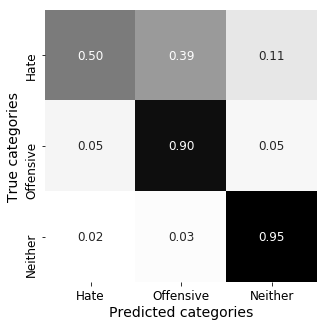

In [86]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(y_test,y_preds)
# matrix_proportions = np.zeros((3,3))
# for i in range(0,3):
#     matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
# names=['Hate','Offensive','Neither']
# confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
# plt.figure(figsize=(5,5))
# seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'True categories',fontsize=14)
# plt.xlabel(r'Predicted categories',fontsize=14)
# plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

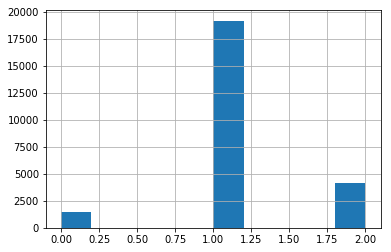

In [87]:
# #True distribution
# y.hist()

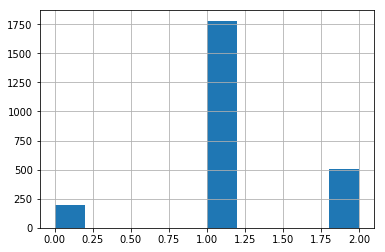

In [88]:
# pd.Series(y_preds).hist()

In [89]:
# print(report)

              precision    recall  f1-score   support

           0       0.44      0.50      0.47       167
           1       0.96      0.90      0.93      1892
           2       0.79      0.95      0.87       420

   micro avg       0.88      0.88      0.88      2479
   macro avg       0.73      0.79      0.75      2479
weighted avg       0.89      0.88      0.89      2479



In [90]:
# confusion_df

,Hate,Offensive,Neither
Hate,0.502994,0.389222,0.107784
Offensive,0.053383,0.900106,0.046512
Neither,0.016667,0.028571,0.954762


In [93]:
from xgboost import XGBClassifier

In [94]:
model = XGBClassifier()
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
# plt.savefig('confusion.pdf')

In [ ]:
confusion_df

In [ ]:
report = classification_report( y_test, predictions )

In [ ]:
print(report)